# Using netMHC predictions

In [4]:
import glob, json
import numpy as np
import pandas as pd
from scipy.stats import entropy
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from lib import *
from IPython.display import display, HTML
#import weblogolib
#from corebio.seq import SeqList, Alphabet

In [5]:
dfbinders = pd.concat(pd.read_csv(filename, sep=',') for filename in glob.glob('/home/amayer/data/peptidome/netmhc/Malaria-HLA-*.csv'))

/home/amayer/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [6]:
totalpeptides = sum(len(seq) for h, seq in fasta_iter(human))
totalpeptides

11518487

In [7]:
counter9 = count_kmers_proteome(malaria, 9)

In [8]:
len(counter9)

3811104

In [9]:
len(dfbinders['Peptide'].unique()), len(np.array(dfbinders['Peptide']))

(1433995, 6034826)

In [10]:
# 50nM = strong binding
# 500nM = weak binding
dfbinders = dfbinders[dfbinders['nM']<500]
dfbinders.head()

,HLA-B5701,Core,H_Avg_Ranks,ID,N_binders,Peptide,Pos,Rank,Unnamed: 0,nM
0,NaN,FVFILSVLI,3.00,sp_C6KT68_FENR_,0.0,FVFILSVLI,4.0,3.00,4.0,260.5
1,NaN,ILSVLISGV,0.06,sp_C6KT68_FENR_,1.0,ILSVLISGV,7.0,0.06,7.0,4.3
2,NaN,VLISGVCCI,1.00,sp_C6KT68_FENR_,1.0,VLISGVCCI,10.0,1.00,10.0,38.2
3,NaN,RMTAHSRFL,1.20,sp_C6KT68_FENR_,1.0,RMTAHSRFL,29.0,1.20,29.0,51.3
4,NaN,NLYTVKNPL,1.20,sp_C6KT68_FENR_,1.0,NLYTVKNPL,62.0,1.20,62.0,52.9


In [ ]:
for filename in glob.glob('/home/amayer/data/peptidome/netmhc/Human-HLA-*.csv'):
    dfbinders = pd.read_csv(filename, sep=',')
    seqs = SeqList(list(dfbinders['Peptide']), alphabet=Alphabet(aminoacids))
    data = weblogolib.LogoData.from_seqs(seqs)
    options = weblogolib.LogoOptions()
    #options.logo_title = 'HLA-A0101'
    f = weblogolib.LogoFormat(data, options)
    svg = weblogolib.svg_formatter(data, f)
    display(HTML(svg.decode('ascii')))

In [12]:
with open('../../data/triplet-human.json', 'r') as f:
    tripletparams = json.load(f)

In [13]:
k = 9
loglikelihood = lambda seq, k: loglikelihood_triplet(seq, **tripletparams, k=k)
phuman = np.array([loglikelihood(seq[i:i+k], k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1) ])

In [37]:
dfepitope['Epitope', 'Description']

6830      SLKKNSRSL
44829     YLNKIQNSL
44840     KPIVQYDNF
44872     GLIMVLSFL
45349     DLLEEGNTL
45350     KLEELHENV
45351     VLDKVEETV
45352     GLLNKLENI
45353     MEKLKELEK
45354     EPKDEIVEV
45428     KPIVQYDNF
45429     KPIVQYDNF
45440     LRKPKHKKL
45442     ASKNKEKAL
45444     KNKEKALII
45446     MPNDPNRNV
45447     MPNDPNRNV
45449     HLGNVKYLV
45452     GIAGGLALL
45453     MINAYLDKL
45488     ASKNKEKAL
45489     KNKEKALII
45490     MPLETQLAI
45491     MPLETQLAI
46066     GLIMVLSFL
46069     YLNKIQNSL
46072     MPNDPNRNV
46176     YLNKIQNSL
46177     LRKPKHKKL
46179     KILSVFFLA
            ...    
109315    YLNKIQNSL
109320    MPNDPNRNV
170798    FEFTYMINF
170800    HPKEYEYPL
170801    YEYPLHQEH
170805    NEFPAIDLF
170809    TQKCEIFNV
170811    NEVVVKEEY
173526    KPIVQYDNF
173527    APFISAVAA
223362    TLDEMRHFY
223364    NEVVVKEEY
255837    KSHGKGYNW
265743    KSHGKGYNW
303887    FLFVEALFQ
303889    FVEALFQEY
303893    IMVLSFLFL
303895    LIMVLSFLF
303896    SFLFVEALF


In [41]:
dfproteomes = load_proteomes()
pathogenproteomes = dfproteomes[dfproteomes['type'].isin(['parasite'])]

dfepitopes = load_iedb_tcellepitopes(human_only=True, positive_only=True, peptide_length=9)
#dfepitopes = pd.read_csv(datadir+'allhuman-iedb-epitopes.csv', header=1, usecols=(2, 9, 14))
iedbname = pathogenproteomes['iedbname'].iloc[0]
dfepitopes = dfepitopes.fillna('')
dfepitope = dfepitopes[dfepitopes['Epitope', 'Parent Species'].str.contains(iedbname)]
#dfepitope = pd.read_csv(datadir+'iedb-Malaria-MHCI-humanhost.csv', header=1, usecols=(2, 9, 14))
#dfepitope['length'] = [len(d) for d in dfepitope['Description']]

In [70]:
len(np.unique(epi))

54

In [71]:
epi = list(dfepitope['Epitope', 'Description'])
epi = np.unique(epi)
pepitope = np.array([loglikelihood(seq, k) for seq in epi])
#epi = list(dfepitope['Description'])
#pepitope = np.array([loglikelihood(seq[i:i+k], k) for seq in epi for i in range(len(seq)-k+1)])
pepitope = pepitope[~np.isnan(pepitope)]

path = datadir + pathogenproteomes['path'].iloc[0]
ppathogen = np.array([loglikelihood(seq[i:i+k], k) for h, seq in fasta_iter(path) for i in range(len(seq)-k+1) ])
ppathogen = ppathogen[~np.isnan(ppathogen)]

print(len(phuman), len(ppathogen), len(pepitope))

11349864 4129446 54


In [63]:
preds = []
for filename in glob.glob('/home/amayer/repos/peptidome/data/netmhc/Malaria-HLA-*.csv'):
    dfbinders = pd.read_csv(filename, sep=',')
    ppredepitope = np.array([loglikelihood(seq, k) for seq in dfbinders['Peptide'].unique()])
    ppredepitope = ppredepitope[~np.isnan(ppredepitope)]
    if len(ppredepitope) > 20:
        preds.append(ppredepitope)

No handles with labels found to put in legend.


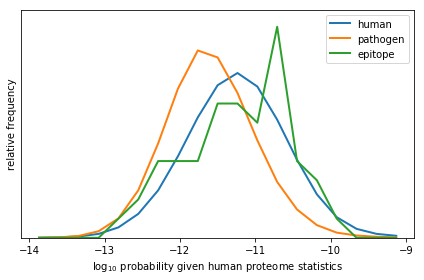

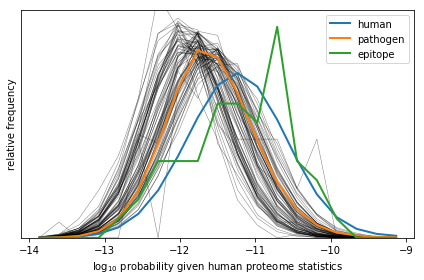

In [72]:
for mhc in [False, True]:
    fig, ax = plt.subplots()
    if mhc:
        plot_histograms(preds,
                        [None]*len(preds),
                        nbins=20, lw=.5, color='k', alpha=.5,
                        xmin=-14, xmax=-9, ax=ax)
    plot_histograms([phuman, ppathogen, pepitope],
                    ['human', 'pathogen', 'epitope'],
                    nbins=20, lw=2,
                    xmin=-14, xmax=-9, ax=ax)
    ax.set_ylabel('relative frequency')
    ax.set_ylim(0.0, 0.22)
    ax.set_yticks([])
    ax.set_xlabel('$\log_{10}$ probability given human proteome statistics')
    fig.tight_layout()
    #fig.savefig('plots/likelihoodprofile-Malaria-triplet-k%i%s.png' % (k, '-mhc' if mhc else ''), dpi=300)
    if mhc:
        fig.savefig('main.png')

In [ ]:
dfepi9 = dfepitope[dfepitope['length'] == 9]

In [ ]:
len(set(dfepi9['Description'])), len(set(dfepi9['Description']) - set(dfbinders['Peptide'].unique()))

In [ ]:
with open('peptides.txt', 'w') as f:
    for item in list(dfepi9['Description']):
        f.write("%s\n" % item)

In [ ]:
!netMHC peptides.txt -xls -xlsfile peptides.csv -a HLA-A0101 -p

In [ ]:
pd.read_csv('peptides.csv', sep='\t', skiprows=1)